# Chương 5: Phân tích Phương sai (ANOVA) và MANOVA

**Mục tiêu:** Kiểm định sự khác biệt về trung bình giữa các nhóm. Từ đó đưa ra quyết định chọn lựa phương án tối ưu.

---

## 5.1. Dẫn nhập: Từ A/B Testing đến Đa biến

### Case Study: Cuộc chiến Khuyến mãi
Một chuỗi siêu thị muốn thử nghiệm 3 chiến lược khuyến mãi để xem cách nào tăng doanh thu tốt nhất:
1.  **Nhóm A:** Giảm giá trực tiếp 20%.
2.  **Nhóm B:** Tặng quà đính kèm.
3.  **Nhóm C:** Voucher mua hàng lần sau.

Họ áp dụng 3 cách này tại 30 cửa hàng khác nhau. Cuối tháng, doanh thu trung bình là: A (100 triệu), B (105 triệu), C (98 triệu).

**Câu hỏi:** Nhóm B cao nhất, nhưng liệu mức chênh lệch 5 triệu so với A có ý nghĩa thống kê không? Hay chỉ do may mắn chọn được cửa hàng đông khách? -> **Cần dùng ANOVA.**

**Nâng cao:** Nếu Giám đốc không chỉ quan tâm Doanh thu mà còn cả **Sự hài lòng khách hàng**? -> **Cần dùng MANOVA.**

## 5.2. Phân tích Phương sai một yếu tố (One-way ANOVA)

### 5.2.1. Logic của ANOVA (F-test)
Tại sao so sánh *Trung bình* mà lại phân tích *Phương sai*?

Chúng ta so sánh 2 nguồn biến động:
1.  **Biến động GIỮA các nhóm (Between-group Variance):** Sự khác biệt do chiến lược khuyến mãi gây ra.
2.  **Biến động TRONG NỘI BỘ nhóm (Within-group Variance):** Sự khác biệt do ngẫu nhiên (sai số).

$$ F = \frac{\text{Biến động giữa các nhóm}}{\text{Biến động trong nội bộ nhóm}} $$

* Nếu $F$ lớn (p-value < 0.05): Sự khác biệt giữa các nhóm là có thật.
* Nếu $F$ nhỏ: Sự khác biệt chỉ là nhiễu.

### 5.2.2. Giả định bắt buộc
*   Các nhóm độc lập.
*   Phân phối chuẩn.
*   **Đồng nhất phương sai (Homogeneity of variance):** Độ phân tán của các nhóm phải tương đương nhau (Kiểm định Levene).

C:\Users\Computer\AppData\Local\Temp\ipykernel_15084\1272461262.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Strategy', y='Revenue', data=df_promo, palette='Set2')


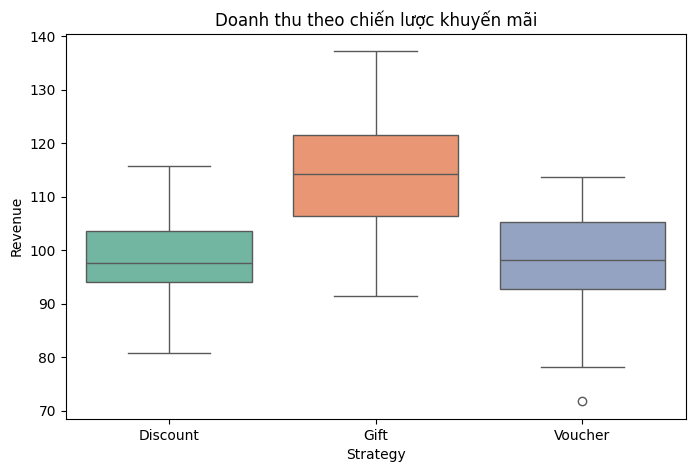

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt

# --- GIẢ LẬP DỮ LIỆU KHUYẾN MÃI ---
np.random.seed(42)
n_per_group = 30

# Doanh thu (Triệu VND)
# Giả sử: Nhóm B thực sự hiệu quả hơn nhóm A và C
rev_A = np.random.normal(100, 10, n_per_group)
rev_B = np.random.normal(115, 12, n_per_group)
rev_C = np.random.normal(98, 10, n_per_group)

df_promo = pd.DataFrame({
    'Revenue': np.concatenate([rev_A, rev_B, rev_C]),
    'Strategy': ['Discount']*n_per_group + ['Gift']*n_per_group + ['Voucher']*n_per_group
})

# --- TRỰC QUAN HÓA ---
plt.figure(figsize=(8, 5))
sns.boxplot(x='Strategy', y='Revenue', data=df_promo, palette='Set2')
plt.title('Doanh thu theo chiến lược khuyến mãi')
plt.show()

In [2]:
# --- THỰC HIỆN ONE-WAY ANOVA ---

# 1. Kiểm tra giả định Levene (Phương sai đồng nhất)
# H0: Phương sai bằng nhau
stat, p_levene = stats.levene(rev_A, rev_B, rev_C)
print(f"Levene Test P-value: {p_levene:.4f}")
if p_levene < 0.05:
    print("Cảnh báo: Phương sai không đồng nhất (Nên dùng Welch ANOVA).")
else:
    print("Thỏa mãn giả định đồng nhất phương sai.")

# 2. Chạy ANOVA
model = ols('Revenue ~ Strategy', data=df_promo).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("\nBảng kết quả ANOVA:")
print(anova_table)

# 3. Phân tích hậu kiểm (Post-hoc Tukey HSD)
# ANOVA chỉ cho biết "Có sự khác biệt", nhưng không nói rõ nhóm nào khác nhóm nào.
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=df_promo['Revenue'], groups=df_promo['Strategy'], alpha=0.05)
print("\nKết quả so sánh từng cặp (Tukey HSD):")
print(tukey)

Levene Test P-value: 0.3537
Thỏa mãn giả định đồng nhất phương sai.

Bảng kết quả ANOVA:
               sum_sq    df          F        PR(>F)
Strategy  4756.985956   2.0  23.453055  7.132969e-09
Residual  8823.110218  87.0        NaN           NaN

Kết quả so sánh từng cặp (Tukey HSD):
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2 meandiff p-adj  lower    upper  reject
-------------------------------------------------------
Discount    Gift  15.4275   0.0   9.2274 21.6276   True
Discount Voucher   0.0103   1.0  -6.1898  6.2104  False
    Gift Voucher -15.4172   0.0 -21.6173 -9.2171   True
-------------------------------------------------------


## 5.3. Phân tích Phương sai Đa biến (MANOVA)

### 5.3.1. Tại sao cần MANOVA?
Khi bạn có nhiều biến phụ thuộc (Dependent Variables - DVs), ví dụ: Doanh thu VÀ Sự hài lòng.
Nếu chạy 2 lần ANOVA riêng lẻ:
1.  **Sai số loại I (Type I Error) tăng lên:** Xác suất tìm thấy sự khác biệt "ảo" tăng.
2.  **Bỏ qua tương quan:** ANOVA không thấy được mối quan hệ giữa Doanh thu và Sự hài lòng.

MANOVA kết hợp các DVs thành một biến tổng hợp (tương tự như biến chính tắc) rồi mới so sánh.

### 5.3.2. Các chỉ số thống kê
*   **Wilks' Lambda:** Phổ biến nhất. Giá trị càng nhỏ càng tốt (cho thấy sự khác biệt lớn).
*   **Pillai's Trace:** Mạnh (robust) nhất khi các giả định bị vi phạm nhẹ.

In [3]:
from statsmodels.multivariate.manova import MANOVA

# --- GIẢ LẬP DỮ LIỆU ĐA BIẾN ---
# Thêm cột 'Satisfaction' (Thang điểm 1-10)
# Giả sử: 
# - Discount: Doanh thu trung bình, Hài lòng thấp (vì khách cảm thấy giá rẻ = hàng ôi).
# - Gift: Doanh thu cao, Hài lòng cao.
# - Voucher: Doanh thu thấp, Hài lòng trung bình.

sat_A = np.random.normal(7.0, 1.0, n_per_group)
sat_B = np.random.normal(8.5, 0.8, n_per_group)
sat_C = np.random.normal(7.5, 1.0, n_per_group)

df_promo['Satisfaction'] = np.concatenate([sat_A, sat_B, sat_C])

# --- THỰC HIỆN MANOVA ---
# Cú pháp: Dep1 + Dep2 ~ Group
maov = MANOVA.from_formula('Revenue + Satisfaction ~ Strategy', data=df_promo)
print(maov.mv_test())

                   Multivariate linear model
                                                               
---------------------------------------------------------------
       Intercept         Value  Num DF  Den DF  F Value  Pr > F
---------------------------------------------------------------
          Wilks' lambda  0.0168 2.0000 86.0000 2515.6703 0.0000
         Pillai's trace  0.9832 2.0000 86.0000 2515.6703 0.0000
 Hotelling-Lawley trace 58.5040 2.0000 86.0000 2515.6703 0.0000
    Roy's greatest root 58.5040 2.0000 86.0000 2515.6703 0.0000
---------------------------------------------------------------
                                                               
---------------------------------------------------------------
          Strategy        Value  Num DF  Den DF  F Value Pr > F
---------------------------------------------------------------
            Wilks' lambda 0.4670 4.0000 172.0000 19.9224 0.0000
           Pillai's trace 0.5679 4.0000 174.0000 17.2494 0.

### 5.3.3. Đọc kết quả MANOVA
*   Nhìn vào phần `Wilks' lambda` hoặc `Pillai's trace`.
*   Nếu **Pr > F** (p-value) < 0.05: Kết luận rằng chiến lược khuyến mãi có tác động đáng kể lên **tổng thể** hiệu quả kinh doanh (gồm cả Tiền và Niềm vui của khách).

---

## 5.4. Tổng kết Chương 5

1.  **One-way ANOVA:** Dùng khi so sánh 1 chỉ số trên nhiều nhóm.
2.  **Post-hoc Test:** Bắt buộc phải làm sau ANOVA để biết chính xác ai thắng ai thua.
3.  **MANOVA:** Dùng khi bức tranh mục tiêu phức tạp (nhiều chỉ số đo lường cùng lúc).

### Bài tập thực hành
Một nhà quản trị nhân sự muốn so sánh hiệu suất làm việc của nhân viên (KPI) và mức độ gắn kết (Engagement) giữa 3 phòng ban: Sales, Marketing, và IT.
* Hãy tạo dữ liệu giả lập.
* Chạy MANOVA để xem phòng ban nào có sự khác biệt tổng thể lớn nhất.